In [23]:
# Remove Future Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# General
import numpy as np
from ta import add_all_ta_features

# Data Management
import pandas as pd
from sklearn.model_selection import train_test_split

# Machine Learning
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

# Binary Classification Specific Metrics
#from sklearn.metrics import plot_roc_curve

# General Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import statsmodels.graphics.tsaplots as sgt
# Reporting
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from xgboost import plot_tree
from statsmodels.tsa.stattools import acf
from ta.trend import MACD
import yfinance

### Data Management

In [27]:
# Data Extraction

# Data Extraction
symbol = "TATACONSUM.NS"

#df = pd.read_csv("./stock_historical_data/{}.csv".format(symbol))
df = yfinance.download (tickers = "{}".format(symbol),start="2000-03-06",
                            interval = "1d", group_by = 'ticker', auto_adjust = True)



df = df[["Open", "High", "Low", "Close","Volume"]]
df["Returns"] = df["Close"].pct_change()
df["Range"] = df["High"] / df["Low"] - 1
df["Avg_Range"] = df["Range"].rolling(window=30).mean()
df.tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume,Returns,Range,Avg_Range
Date,,,,,,,,
2023-07-28,854.250000,860.400024,842.000000,859.349976,2365708,0.010941,0.021853,0.019186
2023-07-31,859.349976,860.849976,852.500000,859.299988,1454789,-0.000058,0.009795,0.018793
2023-08-01,861.900024,863.299988,853.099976,856.750000,987812,-0.002968,0.011956,0.018600
2023-08-02,855.000000,855.000000,838.200012,843.049988,1604731,-0.015991,0.020043,0.018494
2023-08-03,840.000000,841.650024,832.549988,835.400024,1374979,-0.009074,0.010930,0.017914


In [28]:
#adding nifty index
#dfNifty = pd.read_csv("./stock_historical_data/{}.csv".format("^NSEI"))
#dfNifty.set_index("Date", inplace=True)


In [29]:
df = add_all_ta_features(df, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)
df = df.dropna()
df.head()

/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/ta/trend.py:780: RuntimeWarning: invalid value encountered in scalar divide
  dip[idx] = 100 * (self._dip[idx] / value)
/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/ta/trend.py:785: RuntimeWarning: invalid value encountered in scalar divide
  din[idx] = 100 * (self._din[idx] / value)


,Open,High,Low,Close,Volume,Returns,Range,Avg_Range,volume_adi,volume_obv,...,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
Date,,,,,,,,,,,,,,,,,,,,,
2000-04-14,21.458166,21.458166,21.458166,21.458166,0,0.000000,0.000000,0.059032,-1.320972e+06,-6711060,...,-3.828879,-3.589743,-0.239136,2.923967,9.222987,-6.299020,21.694149,0.000000,0.000000,-17.824914
2000-04-17,20.355819,22.923783,19.792120,21.780727,2360340,0.015032,0.158228,0.062463,-6.836782e+05,-4350720,...,-3.756459,-3.623086,-0.133373,14.012063,10.180802,3.831261,21.695661,1.503210,1.492024,-16.589650
2000-04-18,22.547988,23.174321,21.868418,22.676388,1372560,0.041122,0.059716,0.061454,-3.578167e+05,-2978160,...,-3.338820,-3.566233,0.227413,14.470666,11.038775,3.431891,21.752688,4.112169,4.029868,-13.159675
2000-04-19,22.861151,23.174317,21.921651,22.303715,1325680,-0.016434,0.057143,0.060966,-8.748311e+05,-4303840,...,-3.105907,-3.474168,0.368260,14.286776,11.688375,2.598401,21.785969,-1.643441,-1.657095,-14.586845
2000-04-20,21.671115,22.046916,21.608482,21.896595,1408250,-0.018253,0.020290,0.057517,-4.322439e+05,-5712090,...,-3.033481,-3.386030,0.352550,14.480662,12.246832,2.233829,21.789916,-1.825345,-1.842210,-16.145930


In [46]:
# Specify Target
df.loc[df["Close"].shift(-1) > df["Close"], "TARGET"] = 1
df.loc[df["Close"].shift(-1) <= df["Close"], "TARGET"] = 0

In [47]:
# Fill NA
df["TARGET"].fillna(0, inplace=True)
df.tail()

,Open,High,Low,Close,Volume,Returns,Range,Avg_Range,volume_adi,volume_obv,...,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr,TARGET
Date,,,,,,,,,,,,,,,,,,,,,
2023-07-28,854.250000,860.400024,842.000000,859.349976,2365708,0.010941,0.021853,0.019186,-5.291164e+08,1800668583,...,1.103244,-0.122265,7.424660,-1.564023,8.988683,850.488485,1.094052,1.088110,3190.922324,0.0
2023-07-31,859.349976,860.849976,852.500000,859.299988,1454789,-0.000058,0.009795,0.018793,-5.282017e+08,1799213794,...,1.066462,-0.147129,5.406227,-0.169973,5.576200,850.588505,-0.005817,-0.005817,3190.730893,0.0
2023-08-01,861.900024,863.299988,853.099976,856.750000,987812,-0.002968,0.011956,0.018600,-5.284826e+08,1798225982,...,1.020533,-0.183715,1.471876,0.158397,1.313480,850.625242,-0.296752,-0.297193,3180.965591,0.0
2023-08-02,855.000000,855.000000,838.200012,843.049988,1604731,-0.015991,0.020043,0.018494,-5.291608e+08,1796621251,...,0.943431,-0.308407,1.352104,0.397138,0.954966,850.419319,-1.599068,-1.611991,3128.500731,0.0
2023-08-03,840.000000,841.650024,832.549988,835.400024,1374979,-0.009074,0.010930,0.017914,-5.296745e+08,1795246272,...,0.834342,-0.436356,0.088464,0.335404,-0.246939,849.130836,-0.907415,-0.911557,3099.204826,0.0


### Train Test Split

In [48]:
# Split into X and Y Data
X = df.iloc[:, : -1]
y = df.iloc[:, -1]

In [49]:
# Perform Train Test Split (Timeseries based method)
train_size_rate = 0.7
train_size = int(len(X) * train_size_rate)
test_size = len(X) - train_size

X_train = X.head(train_size)
y_train = y.head(train_size)
X_test = X.tail(test_size)
y_test = y.tail(test_size)

size_check = len(y_test) + len(y_train) == len(X)
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)
print("Size Matches: ", size_check)

Shape of X_train:  (4071, 94)
Shape of y_train:  (4071,)
Shape of X_test:  (1746, 94)
Shape of y_test:  (1746,)
Size Matches:  True


### Build Model

In [50]:
# Select type of model to optimize for
is_binary = True
is_optimise_for_precision = True

In [51]:
# Determine Objective and Eval Metrics
if is_binary:
    objective = "binary:logistic"
    eval_metric = "logloss"
    eval_metric_list = ["error", "logloss", eval_metric]
else:
    objective = "multi:softmax"
    eval_metric = "mlogloss"
    eval_metric_list = ["merror", "mlogloss", eval_metric]

In [52]:
# Refine Eval Metric
if is_binary and is_optimise_for_precision:
    eval_metric = "aucpr"
    scoring = "precision"
elif is_binary and not is_optimise_for_precision:
    eval_metric = "auc"
    scoring = "f1"
else:
    scoring = "accuracy"

In [53]:
# Hyperparams: ne: 80, lr: 0.01 md: 3 gm: 6
# ne: 1#15, lr: 0.2 md: 5 gm: 20
#Recommended Params >> ne: 65, lr: 0.05 md: 1 gm: 20

ne = 65
lr = 0.05
md = 1
gm = 20

In [54]:
# XGBOOST Classifier
classifier = XGBClassifier(
    objective=objective,
    booster="gbtree",
    eval_metric=eval_metric,
    n_estimators=ne,
    learning_rate=lr,
    max_depth=md,
    gamma=gm,
    subsample=0.8,
    colsample_bytree=1,
    random_state=1,
    use_label_encoder=False
)

/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


In [55]:
# Fit Model
eval_set = [(X_train, y_train), (X_test, y_test)]
classifier.set_params(eval_metric=eval_metric_list)  # Example metric: 'error'

classifier.fit(X_train, y_train, eval_set=eval_set, verbose=False)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=['error', 'logloss', 'logloss'], feature_types=None,
              gamma=20, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=65, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=1, ...)

### Make Predictions

In [56]:
# Get Predictions Training
train_yhat = classifier.predict(X_train)
train_yhat_proba = classifier.predict_proba(X_train)
print("Preds Training Data: \n", train_yhat[:10])
print("Preds Probabilities Training Data: \n", train_yhat_proba[:3])

Preds Training Data: 
 [0 0 0 0 0 0 0 0 0 0]
Preds Probabilities Training Data: 
 [[0.51079774 0.4892023 ]
 [0.51079774 0.4892023 ]
 [0.51079774 0.4892023 ]]


In [57]:
# Get Predictions Test
test_yhat = classifier.predict(X_test)
test_yhat_proba = classifier.predict_proba(X_test)
print("Preds Test Data: \n", test_yhat[:10])
print("Preds Probabilities Training Data: \n", test_yhat_proba[:3])

Preds Test Data: 
 [0 0 0 0 0 0 0 0 0 0]
Preds Probabilities Training Data: 
 [[0.51079774 0.4892023 ]
 [0.51079774 0.4892023 ]
 [0.51079774 0.4892023 ]]


In [58]:
# Set K-Fold Cross Validation Levels
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)

In [43]:
# Training Results
train_results = cross_val_score(classifier, X_train, y_train, scoring=scoring, cv=cv, n_jobs=1)

/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behav

### Evaluation Metrics  - Loss and Overfitting

In [59]:
# Retrieve performance metrics
results = classifier.evals_result()
epochs = len(results["validation_0"]["error"])
x_axis = range(0, epochs)

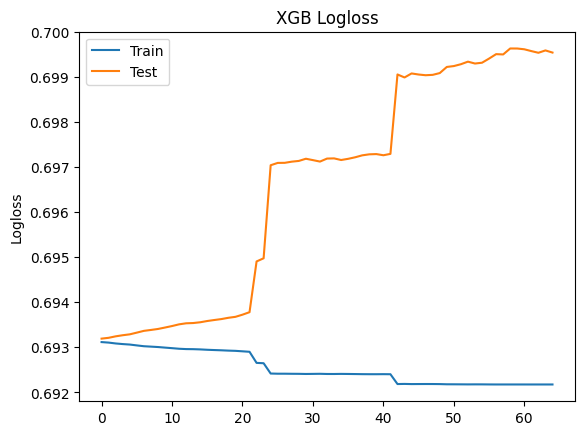

In [45]:
# Plot Log Loss
fig, ax = plt.subplots()
ax.plot(x_axis, results["validation_0"]["logloss"], label="Train")
ax.plot(x_axis, results["validation_1"]["logloss"], label="Test")
ax.legend()
plt.ylabel("Logloss")
plt.title("XGB Logloss")
plt.show()

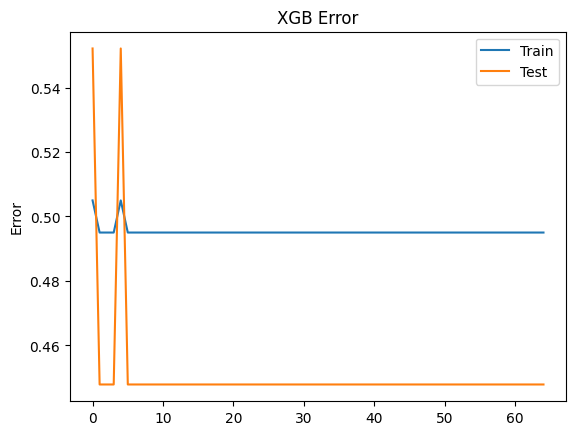

In [20]:
# Plot Classification Error
fig, ax = plt.subplots()
ax.plot(x_axis, results["validation_0"]["error"], label="Train")
ax.plot(x_axis, results["validation_1"]["error"], label="Test")
ax.legend()
plt.ylabel("Error")
plt.title("XGB Error")
plt.show()

### Evaluation Metrics - ROC Curve

In [22]:
# Plot Training ROC Curve
#plot_roc_curve(classifier, X_train, y_train)

In [23]:
# Plot Test ROC Curve
#plot_roc_curve(classifier, X_test, y_test)

### Performance Evaluation Comparison

In [23]:
# Set K-Fold Cross Validation Levels
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)

In [24]:
# Training and Test Results
train_results = cross_val_score(classifier, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1)
test_results = cross_val_score(classifier, X_test, y_test, scoring=scoring, cv=cv, n_jobs=-1)

/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


In [60]:
# Comparison of Results
print("TRAIN:")
print("Average Acc K-Fold", round(train_results.mean(), 2))
print("Std Dev K-Fold", round(train_results.std(), 2))
print("Precision Score 0", round(precision_score(y_train, train_yhat, average=None)[0], 3))
print("Precision Score 1", round(precision_score(y_train, train_yhat, average=None)[1], 3))
print("----- ----- ----- ----- ----- ----- -----")
print("TEST:")
print("Average Acc K-Fold", round(test_results.mean(), 2))
print("Std Dev K-Fold", round(test_results.std(), 2))
print("Precision Score 0", round(precision_score(y_test, test_yhat, average=None)[0], 3))
print("Precision Score 1", round(precision_score(y_test, test_yhat, average=None)[1], 3))
print("")

TRAIN:
Average Acc K-Fold 0.0
Std Dev K-Fold 0.0
Precision Score 0 0.512
Precision Score 1 0.0
----- ----- ----- ----- ----- ----- -----
TEST:


/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


NameError: name 'test_results' is not defined

### Evaluation Metrics - Summary Report

In [61]:
# Show summary report - Training
print(classification_report(y_train, train_yhat))

              precision    recall  f1-score   support

         0.0       0.51      1.00      0.68      2084
         1.0       0.00      0.00      0.00      1987

    accuracy                           0.51      4071
   macro avg       0.26      0.50      0.34      4071
weighted avg       0.26      0.51      0.35      4071



/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

In [62]:
# Show summary report - Test
print(classification_report(y_test, test_yhat))

              precision    recall  f1-score   support

         0.0       0.48      1.00      0.65       843
         1.0       0.00      0.00      0.00       903

    accuracy                           0.48      1746
   macro avg       0.24      0.50      0.33      1746
weighted avg       0.23      0.48      0.31      1746



/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

### Performance Evaluation - Confusion Matrix

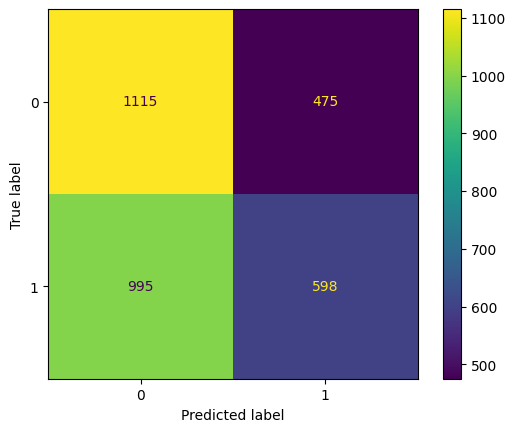

In [28]:
# Training Confusion Matrix
cm_train = confusion_matrix(y_train, train_yhat)
ConfusionMatrixDisplay(cm_train).plot()

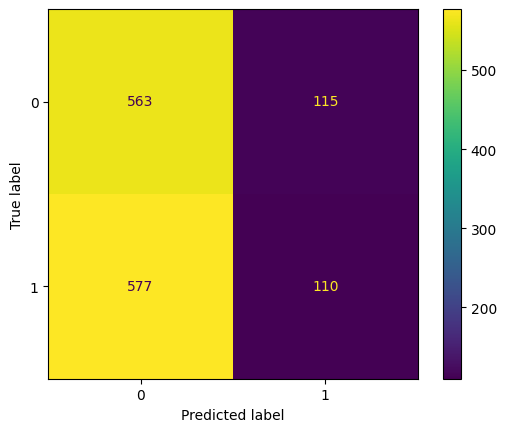

In [29]:
# Test Confusion Matrix
cm_test = confusion_matrix(y_test, test_yhat)
ConfusionMatrixDisplay(cm_test).plot()

### Feature Importance

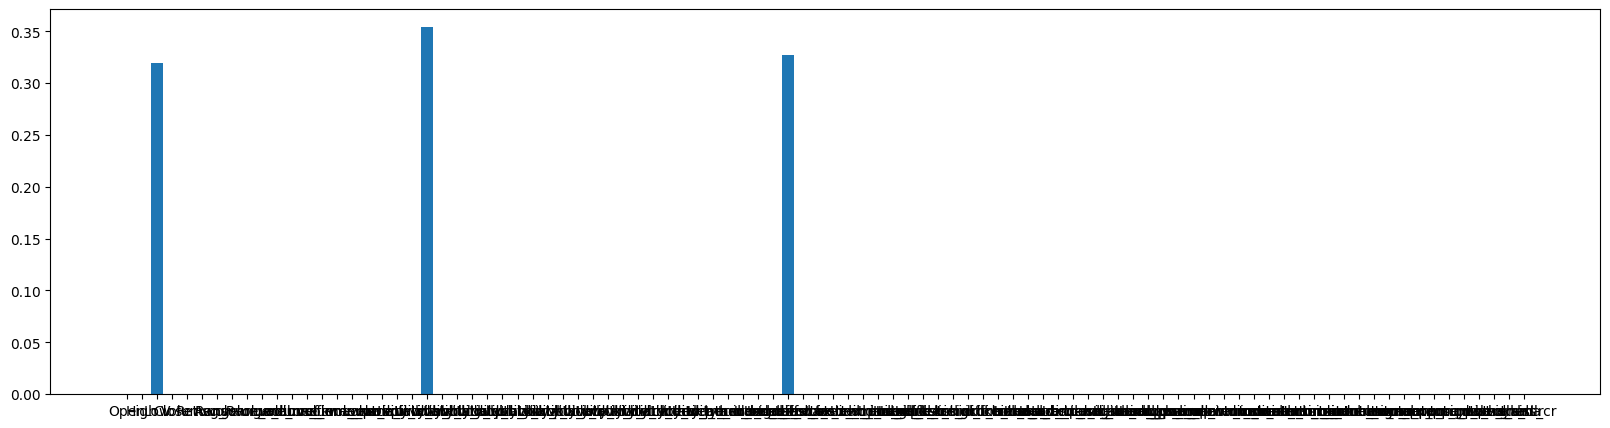

In [63]:
# Plot Feature Importances
fig = plt.figure(figsize=(20, 5))
importance_labels = X.columns
importance_features = classifier.feature_importances_

plt.bar(importance_labels, importance_features)
plt.show()

In [64]:
filtered_numbers = []
filterd_labels = []
filter_score = []
for index,ddd in enumerate(importance_features):
    if ddd > 0.05:
        filter_score.append(ddd)
        filterd_labels.append(importance_labels[index])
       # print(importance_labels[index])
print(filterd_labels)

['Low', 'volatility_bbl', 'trend_ema_fast']


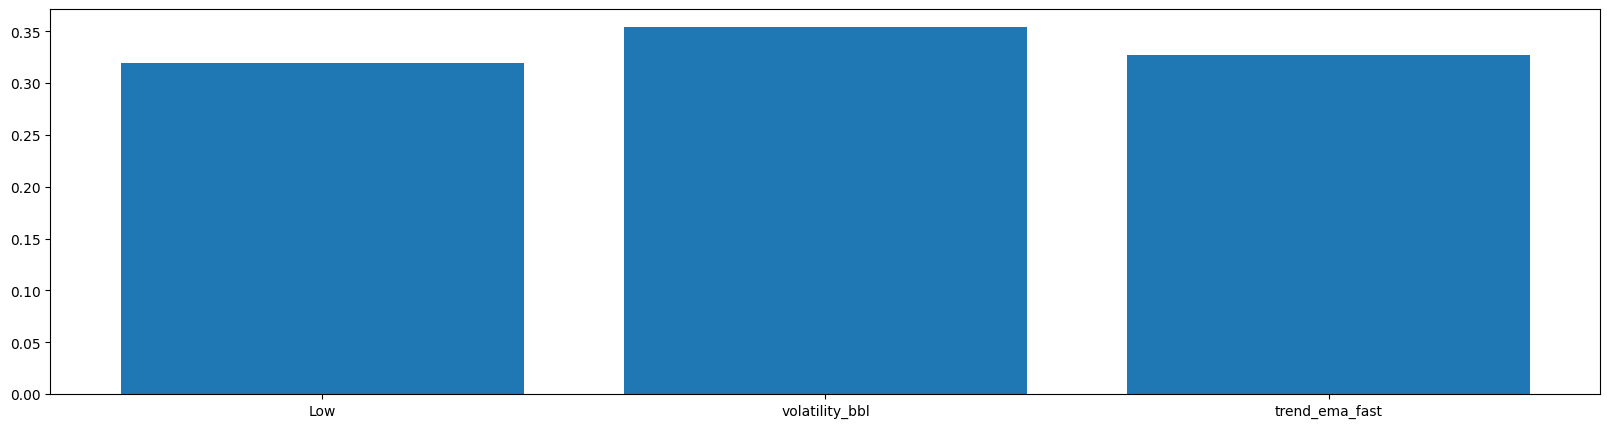

In [65]:
# Plot Feature Importances
fig = plt.figure(figsize=(20, 5))
importance_labels = X.columns
importance_features = classifier.feature_importances_

plt.bar(filterd_labels, filter_score)
plt.show()

In [32]:
#conda install graphviz python-graphviz

### XGBOOST TREE

<Axes: >

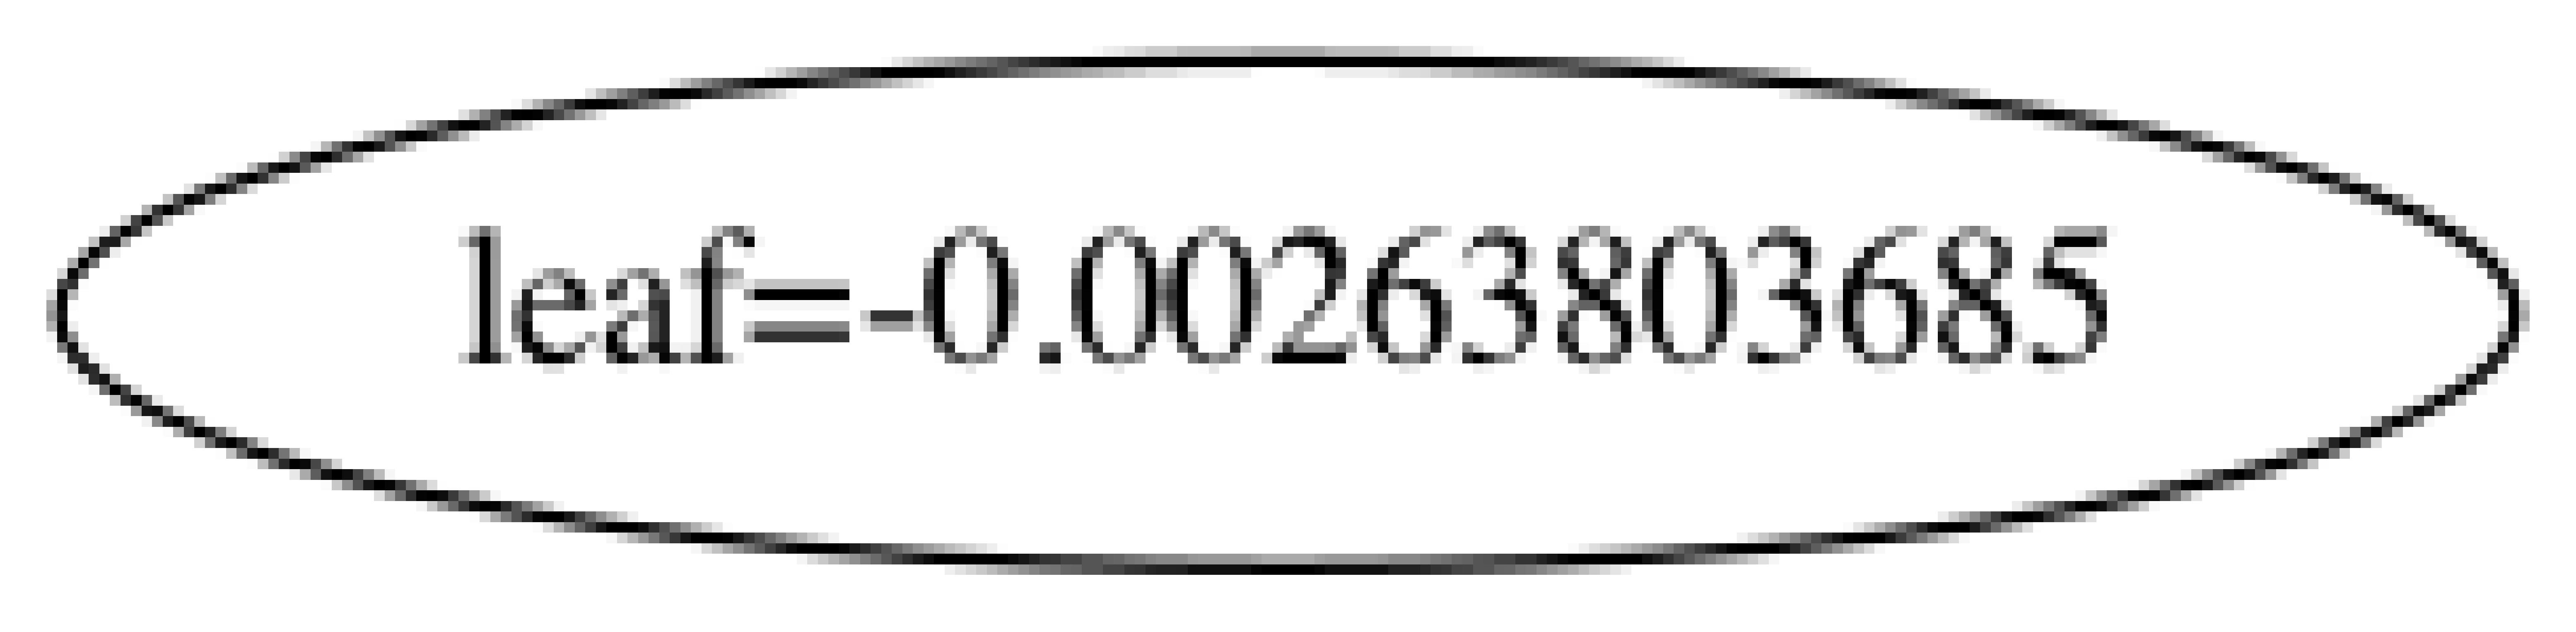

In [66]:
rcParams["figure.figsize"] = 80, 50
plot_tree(classifier)

### Conclusion

We feel that it is possible using Machine Learning, that we can forecast with better than 50/50 odds, whether the Range (our interpretation of volatility) for Bitcoin, can be predicted ahead of of time by at least 1 day into the future. This information could be valuable for MOVE based contracts trading.